# Brevitas

## 1 Traditional Binary Neural Network (MNIST)

### 1.1 Importing and checking hardware

In [176]:
import os
import sys
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import importlib


# for training model
# import brevitas
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import torch.optim as optim

# fracbnn modules
sys.path.append('./src')
import utils as util
import quantization as q
importlib.reload(q)


# # for dataset
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# Checking version
print(f'Torch version: {torch.__version__}')
# i dont get how to use brevitas, many other paper such as fracbnn and reacnet also did not use brevitas actually
# print(f'Brevitas version: {brevitas.__version__}')


# checking hardware
# if torch.cuda.is_available():
print(f'Cuda is available: {torch.cuda.is_available()}')  # should be True
print(f'device: {torch.cuda.get_device_name(0)}')  # should say RTX 3060
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Torch version: 2.8.0+cu128
Cuda is available: True
device: NVIDIA GeForce RTX 3060


## 1.2 Importing dataset

MNIST

In [72]:
dataset_dir = '/home/jovyan/dataset'


training_data = datasets.MNIST(
    root=dataset_dir,
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root=dataset_dir,
    train=False,
    download=True,
    transform=ToTensor()
)

Cifar10

In [2]:
dataset_dir = '/home/jovyan/dataset'


training_data = datasets.CIFAR10(
    root=dataset_dir,
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root=dataset_dir,
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [01:03<00:00, 2.69MB/s]


In [157]:
trainloader = DataLoader(training_data, batch_size=128, shuffle=True)
testloader = DataLoader(test_data, batch_size=128, shuffle=True)

## 1.3 Binary Genetic algorithm

### 1.3.0 Helper

In [24]:
# --- GA Helpers ---
def generate_weight(x, y):
    return 2 * torch.randint(0, 2, (x, y)) - 1  # -1 or 1

def mutate_weight(weight, mutation_rate=0.2):
    x, y = weight.shape
    for i in range(x):
        for j in range(y):
            if random.random() < mutation_rate:
                weight[i, j] *= -1
    return weight

def get_fitness(target, candidate):
    # Fitness = number of matching elements
    return torch.sum(target == candidate).item()

### 1.3.1 Basic

Generation 0: Best fitness = 8
Generation 1: Best fitness = 8
Generation 2: Best fitness = 8
Generation 3: Best fitness = 9
🎯 Found perfect match!


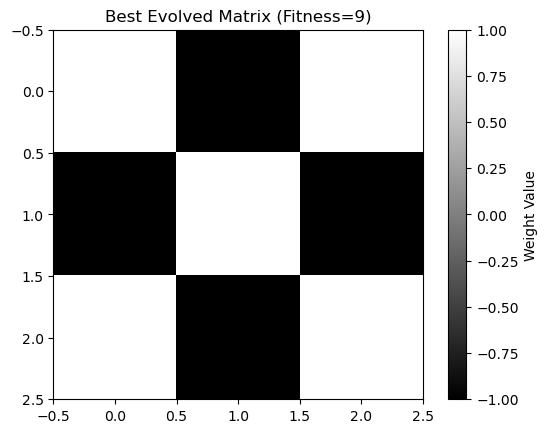

tensor([[ 1, -1,  1],
        [-1,  1, -1],
        [ 1, -1,  1]])


In [25]:
import torch
import random
import matplotlib.pyplot as plt

# Parameters
initial_population = 50
generations = 100
mutation_rate = 0.1
survivor =25



# --- Target ---
target_weight = torch.tensor([[1, -1, 1],
                              [-1, 1, -1],
                              [1, -1, 1]])

# --- Step 1: Initialize population ---
population = [generate_weight(3, 3) for _ in range(initial_population)]

# --- GA Loop ---
for gen in range(generations):
    # Step 2: Evaluate fitness
    fitness_scores = [get_fitness(target_weight, ind) for ind in population]
    
    # Step 3: Select best (elitism: keep top 2)
    sorted_pop = [p for _, p in sorted(zip(fitness_scores, population), key=lambda x: x[0], reverse=True)]
    best = sorted_pop[0]
    best_fitness = max(fitness_scores)
    
    print(f"Generation {gen}: Best fitness = {best_fitness}")
    
    # Stop early if perfect solution found
    if best_fitness == target_weight.numel():
        print("🎯 Found perfect match!")
        break
    
    # Step 4: Create next generation (mutations of top parents)
    new_population = []
    for i in range(initial_population):
        parent = random.choice(sorted_pop[:survivor]).clone()  # pick from top 5
        child = mutate_weight(parent.clone(), mutation_rate)
        new_population.append(child)
    
    population = new_population

# --- Show best solution ---
plt.imshow(best.numpy(), cmap="gray", interpolation="nearest")
plt.colorbar(label="Weight Value")
plt.title(f"Best Evolved Matrix (Fitness={best_fitness})")
plt.show()

print(best)

### 1.3.2 Multi channel

Generation 0: Best fitness = 29
Generation 1: Best fitness = 31
Generation 2: Best fitness = 35
Generation 3: Best fitness = 36
Generation 4: Best fitness = 36
Generation 5: Best fitness = 37
Generation 6: Best fitness = 39
Generation 7: Best fitness = 40
Generation 8: Best fitness = 40
Generation 9: Best fitness = 40
Generation 10: Best fitness = 40
Generation 11: Best fitness = 41
Generation 12: Best fitness = 41
Generation 13: Best fitness = 41
Generation 14: Best fitness = 41
Generation 15: Best fitness = 41
Generation 16: Best fitness = 41
Generation 17: Best fitness = 41
Generation 18: Best fitness = 42
Generation 19: Best fitness = 42
Generation 20: Best fitness = 42
Generation 21: Best fitness = 42
Generation 22: Best fitness = 42
Generation 23: Best fitness = 42
Generation 24: Best fitness = 42
Generation 25: Best fitness = 43
Generation 26: Best fitness = 43
Generation 27: Best fitness = 43
Generation 28: Best fitness = 43
Generation 29: Best fitness = 43
Generation 30: Best 

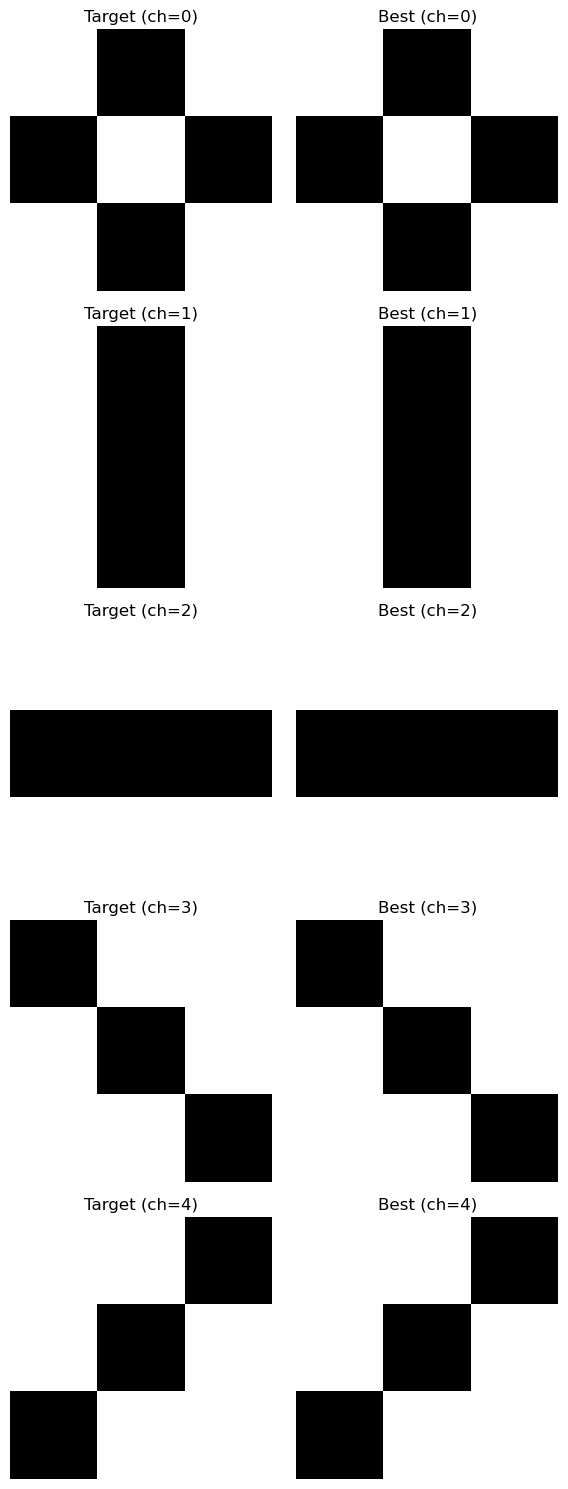

In [35]:
# Multi channel target (5 channel)
target_weight = torch.tensor([[[1, -1, 1],
                              [-1, 1, -1],
                              [1, -1, 1]],

                              [[1, -1, 1],
                              [1, -1, 1],
                              [1, -1, 1]],

                              [[1, 1, 1],
                              [-1, -1, -1],
                              [1, 1, 1]],

                              [[-1, 1, 1],
                              [1, -1, 1],
                              [1, 1, -1]],

                              [[1, 1, -1],
                              [1, -1, 1],
                              [-1, 1, 1]]
                            
                              ])

num_channel = target_weight.shape[0]
population  = 50
generations = 1000

weight = [torch.stack([generate_weight(3, 3) for _ in range(num_channel)]) for _ in range(population)]


# --- GA Loop ---
for gen in range(generations):
    # Step 2: Evaluate fitness
    # population loop
    fitness_scores = []
    for ind in weight:  # each individual is a tensor of shape [num_channel, 3, 3]
        fitness = 0
        for chann in range(num_channel):
            fitness += get_fitness(target_weight[chann], ind[chann])
        fitness_scores.append(fitness)

    # Step 3: Select best (elitism: keep top 2)
    sorted_pop = [p for _, p in sorted(zip(fitness_scores, weight), key=lambda x: x[0], reverse=True)]
    best = sorted_pop[0]
    best_fitness = max(fitness_scores)
    
    print(f"Generation {gen}: Best fitness = {best_fitness}")
    
    # Stop early if perfect solution found
    if best_fitness == target_weight.numel():
        print("🎯 Found perfect match!")
        break
    
    # Step 4: Create next generation (mutations of top parents)
    # Step 4: Create next generation (mutations of top parents)
    weight = []

    for _ in range(population):
        parent = random.choice(sorted_pop[:5]).clone()  # pick a top parent
        child = torch.stack([mutate_weight(parent[ch], mutation_rate) for ch in range(num_channel)])
        new_population.append(child)

    weight = new_population


fig, axes = plt.subplots(num_channel, 2, figsize=(6, 3 * num_channel))

for ch in range(num_channel):
    # Target
    axes[ch, 0].imshow(target_weight[ch].numpy(), cmap="gray", interpolation="nearest")
    axes[ch, 0].set_title(f"Target (ch={ch})")
    axes[ch, 0].axis("off")

    # Best
    axes[ch, 1].imshow(best[ch].numpy(), cmap="gray", interpolation="nearest")
    axes[ch, 1].set_title(f"Best (ch={ch})")
    axes[ch, 1].axis("off")

plt.tight_layout()
plt.show()






## 1.4 Creating VGG-16 binary code

### 1.4.1 Initial VGG using binary weight

In [198]:


class binary_VGG_small(nn.Module):
    def __init__(self, num_classes=10, batch_size=128):
        super(binary_VGG_small, self).__init__()

        ''' The input layer is binarized! '''
        self.conv1 =  q.BinaryConv2d(8, 26, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = q.BinaryConv2d(26, 24, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv3 = q.BinaryConv2d(24, 31, kernel_size=3, stride=1, padding=1, bias=True)
        self.binarize = q.QuantSign.apply
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.linear = q.BinaryLinear(31*7*7, num_classes, bias=False)
        num_gpus = 1
        assert batch_size % num_gpus == 0, \
            "Given batch size cannot evenly distributed to available gpus."
        N = batch_size // num_gpus

        self.encoder = q.InputEncoder(input_size=(1,1,28,28), resolution=32) # 255/32=8 -> from 1 channel becomes 8 channel




    def forward(self, x):
        x = self.encoder(x)
        x = self.binarize(self.conv1(x))
        x = self.binarize(self.conv2(x))
        x = self.pool(x)
        x = self.binarize(x)
        x = self.binarize(self.conv3(x))
        x = self.pool(x)
        x = self.binarize(x)
        x = self.flatten(x)
        out = self.linear(x)
        return out


    def forward_until(self, x, stop='conv2'):
        x = self.encoder(x)
        x = self.binarize(self.conv1(x))
        if stop == 'conv1': return x
        x = self.binarize(self.conv2(x))
        if stop == 'conv2': return x
        x = self.pool(x)
        if stop == 'pool1': return x
        x = self.binarize(self.conv3(x))
        if stop == 'conv3': return x
        x = self.pool(x)
        x = self.binarize(x)
        if stop == 'pool2': return x
        x = self.flatten(x)
        return x


In [199]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = binary_VGG_small(num_classes=10).to(device)
# put input on the same device
input = torch.randn(1, 1, 28, 28).to(device)
output = model(input)
print(output)

cuda
tensor([[ 54.6774, -11.3226, -25.3871, -18.0968, -54.5484,   6.8065, -39.7097,
          14.4194, -39.5806,  28.6774]], device='cuda:0',
       grad_fn=<MmBackward0>)


In [201]:
net = binary_VGG_small(num_classes=10).to(device)
best_acc = 0.0
while (best_acc <97.0):

    criterion = (nn.CrossEntropyLoss().cuda() 
                if torch.cuda.is_available() else nn.CrossEntropyLoss())

    best_model = copy.deepcopy(net.state_dict())
    start_epoch =0
    num_epoch = 100
    initial_lr = 1e-0
    weight_decay = 1e-3
    last_epoch = -1
    save = True

    optimizer = optim.Adam(net.parameters(),
                            lr = initial_lr,
                            weight_decay=weight_decay)


    lr_decay_milestones = [5,10,20,30,40,50,60]
    scheduler = optim.lr_scheduler.MultiStepLR(
                                optimizer,
                                milestones=lr_decay_milestones,
                                gamma=0.1,
                                last_epoch=last_epoch)


    def sparsity(testloader, net, device):
        num_out, num_high = [], []

        def _report_sparsity(m):
            classname = m.__class__.__name__
            if isinstance(m, q.PGBinaryConv2d):
                num_out.append(m.num_out)
                num_high.append(m.num_high)

        net.eval()
        # initialize cnt_out, cnt_high
        net.apply(_report_sparsity)
        cnt_out = np.zeros(len(num_out))
        cnt_high = np.zeros(len(num_high))
        num_out, num_high = [], []

        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = net(images)
                """ calculate statistics per PG layer """
                net.apply(_report_sparsity)
                cnt_out += np.array(num_out)
                cnt_high += np.array(num_high)
                num_out = []
                num_high = []
        print('Sparsity of the update phase: %.1f %%' %
            (100.0-np.sum(cnt_high)*1.0/np.sum(cnt_out)*100.0))


    def test_accu(testloader, net, device):
        correct = 0
        total = 0
        # switch the model to the evaluation mode
        net.eval()
        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100.0 * correct / total
        print('Accuracy of the network on the 10000 test images: %.1f %%' % accuracy)
        return accuracy


    for epoch in range(start_epoch,num_epoch): # loop over the dataset multiple times

        # set printing functions
        batch_time = util.AverageMeter('Time/batch', ':.2f')
        losses = util.AverageMeter('Loss', ':6.2f')
        top1 = util.AverageMeter('Acc', ':6.2f')
        progress = util.ProgressMeter(
                        len(trainloader),
                        [losses, top1, batch_time],
                        prefix="Epoch: [{}]".format(epoch+1)
                        )

        # switch the model to the training mode
        net.train()

        print('current learning rate = {}'.format(optimizer.param_groups[0]['lr']))
        
        # each epoch
        end = time.time()
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            # for name, param in net.named_parameters():
            #     if 'threshold' in name:
            #         loss += (0.00001 * 0.5 *
            #                     torch.norm(param-args.gtarget) *
            #                     torch.norm(param-args.gtarget))
            loss.backward()
            optimizer.step()

            # measure accuracy and record loss
            _, batch_predicted = torch.max(outputs.data, 1)
            batch_accu = 100.0 * (batch_predicted == labels).sum().item() / labels.size(0)
            losses.update(loss.item(), labels.size(0))
            top1.update(batch_accu, labels.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % 100 == 99:    
                # print statistics every 100 mini-batches each epoch
                progress.display(i) # i = batch id in the epoch

        # update the learning rate
        
        if scheduler is not None:
            scheduler.step()

        # print test accuracy every few epochs
        if epoch % 1 == 0:
            print('epoch {}'.format(epoch+1))
            epoch_acc = test_accu(testloader, net, device)
            # sparsity(testloader, net, device)
            if epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(net.state_dict())
                # save the model if required
                if save:
                    print("Saving the trained model and states.")
                    save_folder = os.path.join('save_MNIST_model')
                    util.save_models(best_model, save_folder,
                            suffix='-finetune')
                    """
                    states = {'epoch':epoch+1, 
                                'optimizer':optimizer.state_dict(), 
                                'scheduler':scheduler.state_dict()}
                    util.save_states(states, save_folder, suffix=_ARCH)
                #     """
            print("The best test accuracy so far: {:.1f}".format(best_acc))

        if epoch == 70:
            optimizer = optim.SGD(net.parameters(), lr=0.0000001, momentum=0.5, weight_decay=1e-3)
            scheduler = None  # or a new one


        # if epoch > 10 and epoch_acc < 20.0:
        #     print('Early stopping as the accuracy is not good enough.')
        #     break

        # if epoch > 20 and epoch_acc < 94.0:
        #     print('Early stopping as the accuracy is not good enough.')
        #     break

print('Finished Training')


current learning rate = 1.0
Epoch: [1][ 99/469]	Loss  87.90	Acc  29.23	Time/batch 0.01
Epoch: [1][199/469]	Loss  62.51	Acc  39.14	Time/batch 0.01
Epoch: [1][299/469]	Loss  53.55	Acc  44.24	Time/batch 0.01
Epoch: [1][399/469]	Loss  48.59	Acc  46.13	Time/batch 0.01
epoch 1
Accuracy of the network on the 10000 test images: 61.7 %
Saving the trained model and states.
The best test accuracy so far: 61.7
current learning rate = 1.0
Epoch: [2][ 99/469]	Loss  30.04	Acc  55.60	Time/batch 0.01
Epoch: [2][199/469]	Loss  31.04	Acc  53.06	Time/batch 0.01
Epoch: [2][299/469]	Loss  29.58	Acc  53.49	Time/batch 0.01
Epoch: [2][399/469]	Loss  30.74	Acc  52.89	Time/batch 0.01
epoch 2
Accuracy of the network on the 10000 test images: 32.9 %
The best test accuracy so far: 61.7
current learning rate = 1.0
Epoch: [3][ 99/469]	Loss  34.11	Acc  51.88	Time/batch 0.01
Epoch: [3][199/469]	Loss  31.93	Acc  53.14	Time/batch 0.01
Epoch: [3][299/469]	Loss  31.75	Acc  52.70	Time/batch 0.01
Epoch: [3][399/469]	Loss  31

In [14]:
print("Saving the trained model and states.")
save_folder = os.path.join('save_MNIST_model')
util.save_models(best_model, save_folder,
    suffix='-finetune')

Saving the trained model and states.


### 1.4.1 Ground Truth

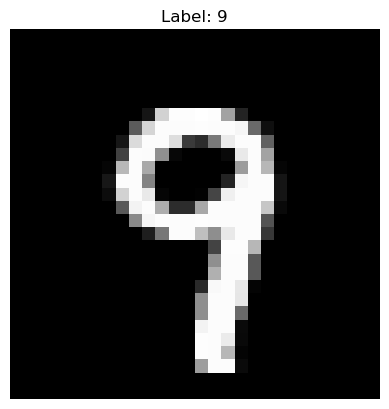

Output logits: tensor([[-22.0323, -32.0968,  21.1290,  82.4194,  71.6452,  67.0645, -84.8065,
         101.0645,  96.8710, 177.9677]], device='cuda:0')
Predicted class: 9


In [104]:
single_image_loader = DataLoader(test_data, batch_size=1, shuffle=True)

data_iter = iter(single_image_loader)
x, y = next(data_iter)   # x: (1, 1, 28, 28), y: (1,)
outputs = {}

# --- 3. Plot it ---
plt.imshow(x[0][0], cmap='gray')
plt.title(f"Label: {y.item()}")
plt.axis('off')
plt.show()

# --- 4. Send to device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = x.to(device)
y = y.to(device)

# --- 5. Forward through model ---
with torch.no_grad():
    output = net(x)

print("Output logits:", output)
print("Predicted class:", torch.argmax(output, dim=1).item())

In [106]:
x, _ = next(iter(single_image_loader))
x = x.to(device)
features = net.forward_until(x, stop='conv2')
print(features)


tensor([[[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  0.7419],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000,  1.0000,  1.0000],
          [-1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-1.0000, -1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [-1.0000, -1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000,  1.0000,  1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000,  1.0000]],

         [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  

## 1.5 CIFAR10

In [26]:


class binary_VGG_small(nn.Module):
    def __init__(self, num_classes=10, batch_size=128):
        super(binary_VGG_small, self).__init__()

        ''' The input layer is binarized! '''
        self.conv1 =  q.BinaryConv2d(24, 64, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = q.BinaryConv2d(64, 96, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv3 = q.BinaryConv2d(96, 96, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv4 = q.BinaryConv2d(96, 128, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv5 = q.BinaryConv2d(128, 192, kernel_size=3, stride=1, padding=1, bias=True)
        self.binarize = q.QuantSign.apply
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.linear1 = q.BinaryLinear(192*2*2, 256)
        self.linear2 = q.BinaryLinear(192*2*2,num_classes)
        num_gpus = 1
        assert batch_size % num_gpus == 0, \
            "Given batch size cannot evenly distributed to available gpus."
        N = batch_size // num_gpus

        self.encoder = q.InputEncoder(input_size=(1,3,32,32), resolution=32) # 255/32=8 -> from 1 channel becomes 8 channel




    def forward(self, x):
        x = self.encoder(x)
        x = self.binarize(self.conv1(x))
        x = self.binarize(self.conv2(x))
        x = self.pool(x)
        x = self.binarize(x)
        x = self.binarize(self.conv3(x))
        x = self.pool(x)
        x = self.binarize(x)
        x = self.binarize(self.conv4(x))
        x = self.pool(x)
        x = self.binarize(x)
        x = self.binarize(self.conv5(x))
        x = self.pool(x)
        x = self.binarize(x)
        x = self.flatten(x)
        out = self.linear2(x)
        return out


    def forward_until(self, x, stop='conv2'):
        x = self.encoder(x)
        x = self.binarize(self.conv1(x))
        if stop == 'conv1': return x
        x = self.binarize(self.conv2(x))
        if stop == 'conv2': return x
        x = self.pool(x)
        if stop == 'pool1': return x
        x = self.binarize(self.conv3(x))
        if stop == 'conv3': return x
        x = self.pool(x)
        x = self.binarize(x)
        if stop == 'pool2': return x
        x = self.flatten(x)
        return x


In [27]:
net = binary_VGG_small(num_classes=10).to(device)

criterion = (nn.CrossEntropyLoss().cuda() 
            if torch.cuda.is_available() else nn.CrossEntropyLoss())

best_acc = 0.0
best_model = copy.deepcopy(net.state_dict())
start_epoch =0
num_epoch = 50
initial_lr = 1e1
weight_decay = 1e-3
last_epoch = -1
save = False

optimizer = optim.Adam(net.parameters(),
                          lr = initial_lr,
                          weight_decay=weight_decay)


lr_decay_milestones = [2,4,5,10,15,20,25,30,40]
scheduler = optim.lr_scheduler.MultiStepLR(
                            optimizer,
                            milestones=lr_decay_milestones,
                            gamma=0.1,
                            last_epoch=last_epoch)


def sparsity(testloader, net, device):
    num_out, num_high = [], []

    def _report_sparsity(m):
        classname = m.__class__.__name__
        if isinstance(m, q.PGBinaryConv2d):
            num_out.append(m.num_out)
            num_high.append(m.num_high)

    net.eval()
    # initialize cnt_out, cnt_high
    net.apply(_report_sparsity)
    cnt_out = np.zeros(len(num_out))
    cnt_high = np.zeros(len(num_high))
    num_out, num_high = [], []

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            """ calculate statistics per PG layer """
            net.apply(_report_sparsity)
            cnt_out += np.array(num_out)
            cnt_high += np.array(num_high)
            num_out = []
            num_high = []
    print('Sparsity of the update phase: %.1f %%' %
          (100.0-np.sum(cnt_high)*1.0/np.sum(cnt_out)*100.0))


def test_accu(testloader, net, device):
    correct = 0
    total = 0
    # switch the model to the evaluation mode
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    print('Accuracy of the network on the 10000 test images: %.1f %%' % accuracy)
    return accuracy


for epoch in range(start_epoch,num_epoch): # loop over the dataset multiple times

    # set printing functions
    batch_time = util.AverageMeter('Time/batch', ':.2f')
    losses = util.AverageMeter('Loss', ':6.2f')
    top1 = util.AverageMeter('Acc', ':6.2f')
    progress = util.ProgressMeter(
                    len(trainloader),
                    [losses, top1, batch_time],
                    prefix="Epoch: [{}]".format(epoch+1)
                    )

    # switch the model to the training mode
    net.train()

    print('current learning rate = {}'.format(optimizer.param_groups[0]['lr']))
    
    # each epoch
    end = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # for name, param in net.named_parameters():
        #     if 'threshold' in name:
        #         loss += (0.00001 * 0.5 *
        #                     torch.norm(param-args.gtarget) *
        #                     torch.norm(param-args.gtarget))
        loss.backward()
        optimizer.step()

        # measure accuracy and record loss
        _, batch_predicted = torch.max(outputs.data, 1)
        batch_accu = 100.0 * (batch_predicted == labels).sum().item() / labels.size(0)
        losses.update(loss.item(), labels.size(0))
        top1.update(batch_accu, labels.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 100 == 99:    
            # print statistics every 100 mini-batches each epoch
            progress.display(i) # i = batch id in the epoch

    # update the learning rate
    scheduler.step()

    # print test accuracy every few epochs
    if epoch % 1 == 0:
        print('epoch {}'.format(epoch+1))
        epoch_acc = test_accu(testloader, net, device)
        # sparsity(testloader, net, device)
        if epoch_acc >= best_acc:
            best_acc = epoch_acc
            best_model = copy.deepcopy(net.state_dict())
        print("The best test accuracy so far: {:.1f}".format(best_acc))

        # save the model if required
        if save:
            print("Saving the trained model and states.")
            save_folder = os.path.join('save_MNIST_model')
            util.save_models(best_model, save_folder,
                    suffix='-finetune')
            """
            states = {'epoch':epoch+1, 
                        'optimizer':optimizer.state_dict(), 
                        'scheduler':scheduler.state_dict()}
            util.save_states(states, save_folder, suffix=_ARCH)
        #     """

print('Finished Training')


current learning rate = 10.0
Epoch: [1][ 99/391]	Loss 129.43	Acc   9.58	Time/batch 0.03
Epoch: [1][199/391]	Loss  95.26	Acc  10.07	Time/batch 0.03
Epoch: [1][299/391]	Loss  81.66	Acc  10.16	Time/batch 0.03
epoch 1
Accuracy of the network on the 10000 test images: 10.0 %
The best test accuracy so far: 10.0
current learning rate = 10.0
Epoch: [2][ 99/391]	Loss  50.73	Acc  10.46	Time/batch 0.03
Epoch: [2][199/391]	Loss  52.02	Acc  10.52	Time/batch 0.03
Epoch: [2][299/391]	Loss  52.46	Acc  10.43	Time/batch 0.03
epoch 2
Accuracy of the network on the 10000 test images: 11.4 %
The best test accuracy so far: 11.4
current learning rate = 1.0
Epoch: [3][ 99/391]	Loss  20.74	Acc  10.48	Time/batch 0.03
Epoch: [3][199/391]	Loss  24.91	Acc  10.29	Time/batch 0.03
Epoch: [3][299/391]	Loss  27.16	Acc  10.34	Time/batch 0.03
epoch 3
Accuracy of the network on the 10000 test images: 11.6 %
The best test accuracy so far: 11.6
current learning rate = 1.0
Epoch: [4][ 99/391]	Loss  31.26	Acc  10.54	Time/batc

## 1.6 Component Ground Truth

In [110]:
class thermal_encoder(nn.Module):
    def __init__(self, num_classes=10, batch_size=128):
        super(thermal_encoder, self).__init__()

        ''' The input layer is binarized! '''
        num_gpus = 1
        assert batch_size % num_gpus == 0, \
            "Given batch size cannot evenly distributed to available gpus."
        N = batch_size // num_gpus

        self.encoder = q.InputEncoder(input_size=(1,1,1,1), resolution=32) # 255/32=8 -> from 1 channel becomes 8 channel




    def forward(self, x):
        out = self.encoder(x)
        return out
    
encoder = thermal_encoder().to(device)

In [111]:
# create a single 1x1 tensor
test_pixel = 16+32*0
print("Test pixel value (0-255):", test_pixel)

test_pixel = torch.tensor([[[test_pixel/255]]]).to(device)
encoded_pixel = encoder(test_pixel)
print("Encoded pixel:", encoded_pixel)

Test pixel value (0-255): 16
Encoded pixel: tensor([[[[ 1.]],

         [[-1.]],

         [[-1.]],

         [[-1.]],

         [[-1.]],

         [[-1.]],

         [[-1.]],

         [[-1.]]]], device='cuda:0')
